<a href="https://colab.research.google.com/github/walnashgit/ERAV2/blob/main/S7/S7_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from gdrive.MyDrive.ERA.S7.model_1 import Network

In [3]:
# Create simple transform and calculate mean and std dev.
simple_transforms = transforms.Compose([
    transforms.ToTensor()
])
exp = datasets.MNIST('./data', train = True, download = True, transform = simple_transforms)
exp_data = exp.transform(exp.data.numpy())

print("EXP")
print(' - Numpy Shape:', exp.data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))


100%|██████████| 9912422/9912422 [00:00<00:00, 154680176.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43216444.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36133561.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24581327.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

EXP
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
#Prepare basic transforms using mean and std from above.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [5]:
#Download data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [6]:
# Create data loader

SEED = 4

cuda = torch.cuda.is_available()
print("CUDA available: ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader args would be user input
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 2, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 128)

# Train loader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA available:  True


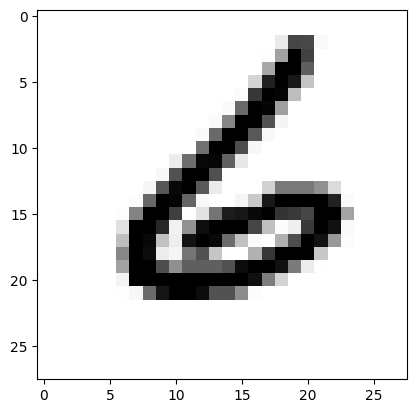

In [7]:
# Data visualization
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.imshow(images[0].squeeze(), cmap='gray_r')

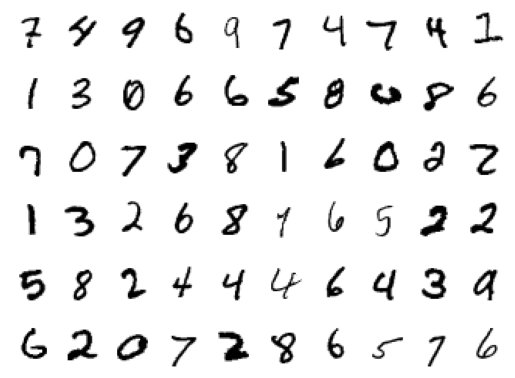

In [8]:
# check data to decide correct transforms needed.
# figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:
# Model summary

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 10, 14, 14]           1,450
            Conv2d-5           [-1, 10, 14, 14]             910
         MaxPool2d-6             [-1, 10, 7, 7]               0
            Conv2d-7             [-1, 16, 5, 5]           1,456
            Conv2d-8             [-1, 16, 3, 3]           2,320
            Conv2d-9             [-1, 10, 1, 1]           1,450
Total params: 10,066
Trainable params: 10,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.04
Estimated Total Size (MB): 0.29
----------------------------------------

In [10]:
# Training and Testing code
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
# Running the model
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12011206895112991 Batch_id=468 Accuracy=54.55: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.1655, Accuracy: 9513/10000 (95.13%)

EPOCH: 1


Loss=0.0460507869720459 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]



Test set: Average loss: 0.0864, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.0659930557012558 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]



Test set: Average loss: 0.0663, Accuracy: 9798/10000 (97.98%)

EPOCH: 3


Loss=0.03192796930670738 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]



Test set: Average loss: 0.0530, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.009724575094878674 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]



Test set: Average loss: 0.0500, Accuracy: 9835/10000 (98.35%)

EPOCH: 5


Loss=0.005715854931622744 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]



Test set: Average loss: 0.0396, Accuracy: 9868/10000 (98.68%)

EPOCH: 6


Loss=0.015405497513711452 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0467, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Loss=0.004836612846702337 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]



Test set: Average loss: 0.0396, Accuracy: 9875/10000 (98.75%)

EPOCH: 8


Loss=0.02436956577003002 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]



Test set: Average loss: 0.0385, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.00243700435385108 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]



Test set: Average loss: 0.0323, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.04078666493296623 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]



Test set: Average loss: 0.0423, Accuracy: 9858/10000 (98.58%)

EPOCH: 11


Loss=0.015566046349704266 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]



Test set: Average loss: 0.0354, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.035868894308805466 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]



Test set: Average loss: 0.0381, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.064799465239048 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]



Test set: Average loss: 0.0383, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.016604317352175713 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]



Test set: Average loss: 0.0321, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.08144859224557877 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]



Test set: Average loss: 0.0329, Accuracy: 9909/10000 (99.09%)

EPOCH: 16


Loss=0.012320124544203281 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]



Test set: Average loss: 0.0339, Accuracy: 9898/10000 (98.98%)

EPOCH: 17


Loss=0.0009676447953097522 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]



Test set: Average loss: 0.0360, Accuracy: 9898/10000 (98.98%)

EPOCH: 18


Loss=0.028256280347704887 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]



Test set: Average loss: 0.0524, Accuracy: 9863/10000 (98.63%)

EPOCH: 19


Loss=0.009212353266775608 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]



Test set: Average loss: 0.0419, Accuracy: 9891/10000 (98.91%)



Text(0.5, 1.0, 'Test Accuracy')

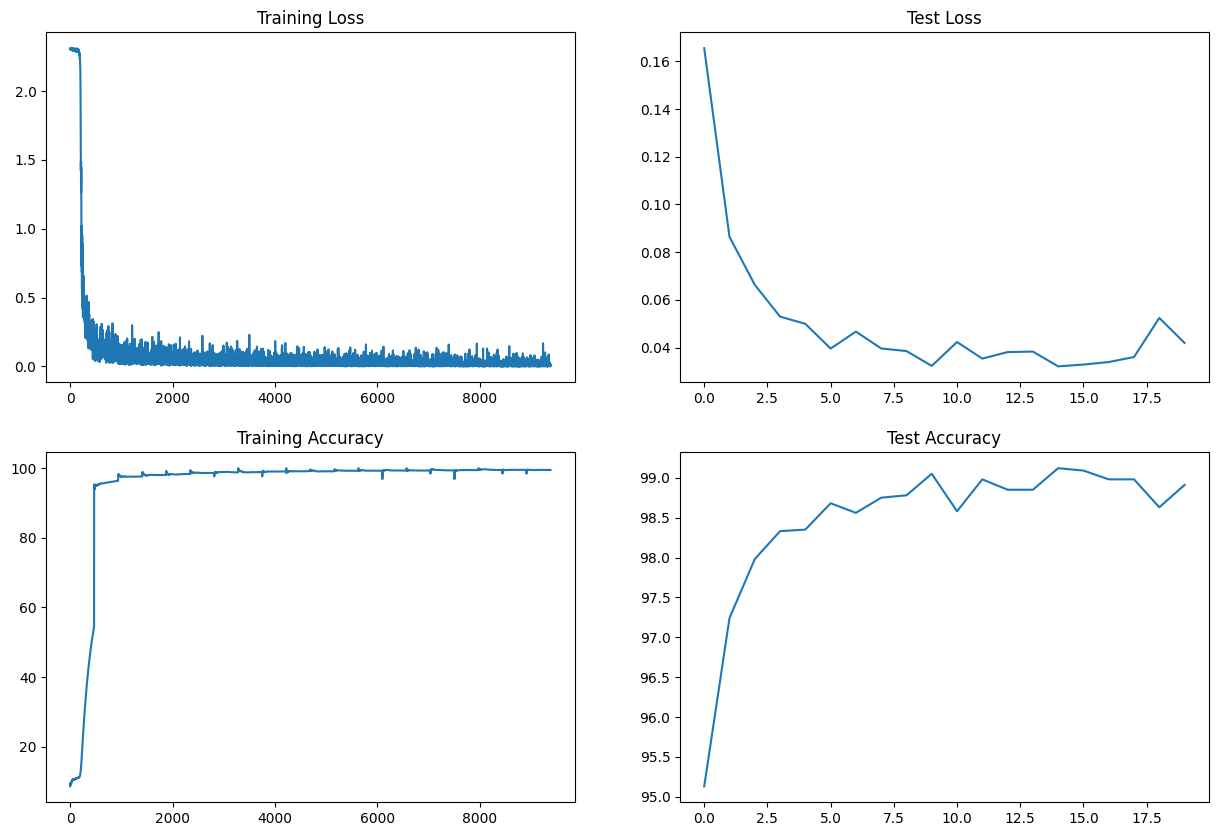

In [12]:
# Plot the training and test loss and accuracy
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target:


1. Create the basic setup for data, transform, model, training and test code.
2. Create an initial model focussed on achieving the required receptive field (min 28) and keeping the model light with total params under 15k.

# Result


1. Total params: 10,066
2. Best training accuracy: 99.5%
3. Best test accuracy: 99.12%



# Analysis



1. Model is light (only 10k param). [Model](https://github.com/walnashgit/ERAV2/blob/main/S7/model1/model_1.py)
2. Bit of overfitting is there.
3. Doesnt look like model would improve test accuracy even if run for more epochs as it has mostly stagnated at around 99%. Training accuracy has also stagnated around 99.5%.





